In [1]:
pip install pyro-ppl

     |████████████████████████████████| 718 kB 7.0 MB/s 
     |████████████████████████████████| 750.6 MB 11 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.


In [2]:
import os
import torch
from torch.distributions import constraints
from torch import tensor

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist
from pyro.infer import SVI,Trace_ELBO
from pyro.infer.autoguide  import AutoMultivariateNormal, AutoNormal, init_to_mean
from pyro.optim import ClippedAdam

assert pyro.__version__.startswith('1.8')
pyro.set_rng_seed(1)
torch.manual_seed(1)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')
plt.rcParams['figure.figsize'] = [12, 8]

In [3]:
from sklearn.datasets import load_iris

X_df, y = load_iris(as_frame=True, return_X_y=True)

In [4]:
target_names = ['setosa', 'versicolor', 'virginica']

In [5]:
# standardize X
X_df.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
X = X_df.apply(lambda x: (x - x.mean())/x.std(), axis=0)
X.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

X['iris_type'] = y
X['is_setosa'] = np.where(X['iris_type'].values == 0, 1,0)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   iris_type     150 non-null    int64  
 5   is_setosa     150 non-null    int64  
dtypes: float64(4), int64(2)
memory usage: 7.2 KB


In [6]:
X.head()

,sepal_length,sepal_width,petal_length,petal_width,iris_type,is_setosa
0,-0.897674,1.015602,-1.335752,-1.311052,0,1
1,-1.139200,-0.131539,-1.335752,-1.311052,0,1
2,-1.380727,0.327318,-1.392399,-1.311052,0,1
3,-1.501490,0.097889,-1.279104,-1.311052,0,1
4,-1.018437,1.245030,-1.335752,-1.311052,0,1


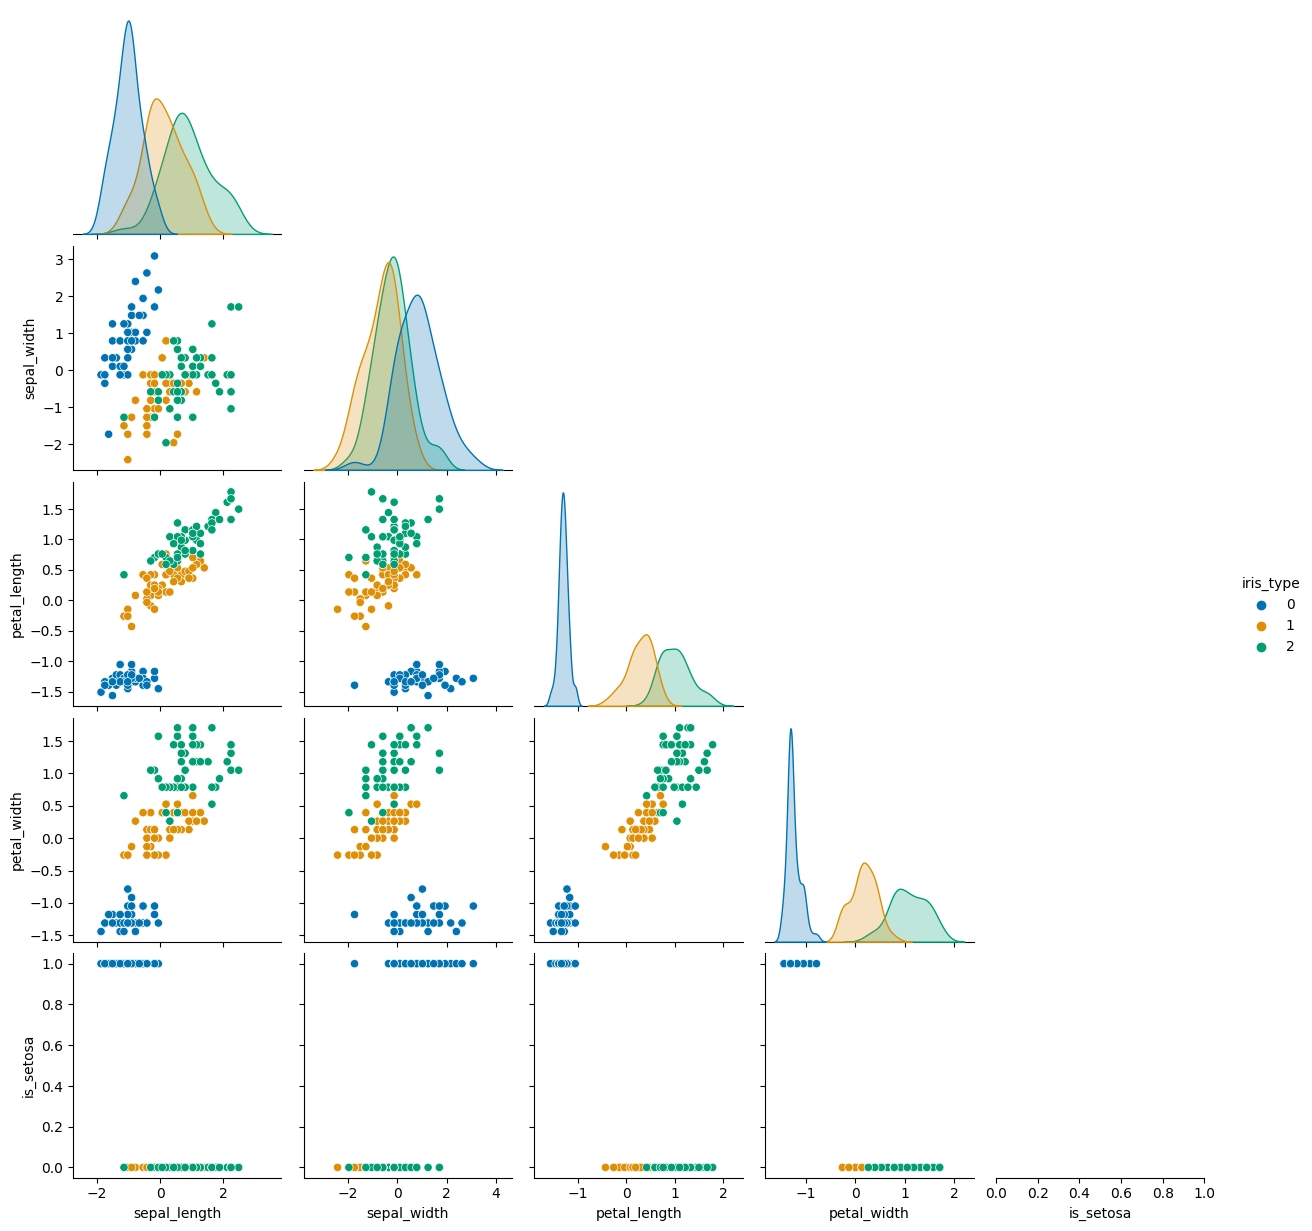

In [7]:
sns.pairplot(data=X, hue='iris_type', palette="colorblind", corner=True); #setosa is easy to distinguish, versicolor and virginica are harder

## Make a logistic regression model of 
is_setosa ~ 'petal_width'

### Using sklearn

In [8]:
X['petal_width'].shape, X['is_setosa'].shape

((150,), (150,))

In [9]:
from sklearn.linear_model import LogisticRegression
#C = 1e9 means no L2 regularization
clf = LogisticRegression(C=1e9, random_state=0).fit(X['petal_width'].values.reshape(-1,1), X['is_setosa'])


In [10]:
# these are the parameters we expect to recover
print(clf.coef_)
print(clf.intercept_)

[[-38.69692782]]
[-21.54793048]


In [11]:
data = tensor(X[['petal_width']].values, dtype=torch.float)
target = tensor(X['is_setosa'].values, dtype=torch.float)

In [12]:
data.size(), target.size()

(torch.Size([150, 1]), torch.Size([150]))

## Using Pyro

In [13]:
from torch import nn
from pyro.nn import PyroSample, PyroModule

class BayesianLogisticRegression(PyroModule):
    def __init__(self, in_features, out_features = 1, bias = True):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(-35., 5.).expand([out_features, in_features]).to_event(2))
        if bias:
          self.linear.bias = PyroSample(dist.Uniform(-25., 5.).expand([out_features]).to_event(1))
        
    def forward(self, x, y=None):
        logits = self.linear(x).squeeze(-1)

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Bernoulli(logits=logits), obs=y)
        return logits

In [14]:
data.size(1)

1

In [15]:
model = BayesianLogisticRegression(data.size(1))

In [16]:
from pyro.infer.autoguide import AutoMultivariateNormal

guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)

In [17]:
def train(model, guide, lr=0.01, n_steps=2000):
    pyro.set_rng_seed(1)
    pyro.clear_param_store()
    
    gamma = 0.01  # final learning rate will be gamma * initial_lr
    lrd = gamma ** (1 / n_steps)
    adam = pyro.optim.ClippedAdam({'lr': lr, 'lrd': lrd})

    svi = SVI(model, guide, adam, loss=Trace_ELBO())

    for i in range(n_steps):
        elbo = svi.step(data, target)
        if i % 500 == 0:
          print(f"Elbo loss: {elbo}")

In [18]:
%%time
train(model, guide)

Elbo loss: 9.350290536880493
Elbo loss: 2.805009201169014
Elbo loss: 1.4718698005599435
Elbo loss: 1.9484067456796765
CPU times: user 12.2 s, sys: 90.6 ms, total: 12.3 s
Wall time: 17.5 s


In [19]:
from pyro.infer import Predictive

num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)

svi_samples = {k: v.reshape((num_samples,-1)).detach().cpu().numpy()
               for k, v in predictive(data, target).items()
               if k != "obs"}

In [20]:
svi_samples.keys()

dict_keys(['linear.weight', 'linear.bias'])

In [21]:
svi_samples['linear.bias'].mean()

-16.362192

In [22]:
svi_samples['linear.weight'].mean(axis=0)

array([-34.34986], dtype=float32)

In [23]:
guide.quantiles([0.05,0.50,0.95])

{'linear.bias': tensor([[-20.3906],
         [-16.5955],
         [-11.3549]]), 'linear.weight': tensor([[[-37.1637]],
 
         [[-34.3472]],
 
         [[-31.5306]]])}

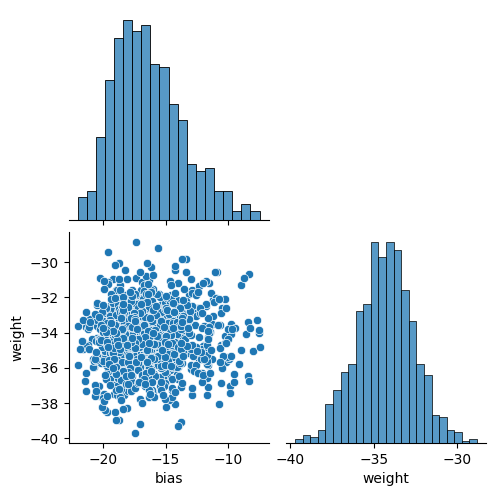

In [24]:
samples = pd.DataFrame({'bias':svi_samples['linear.bias'].squeeze(), 'weight':svi_samples['linear.weight'].squeeze()})
sns.pairplot(data=samples, corner=True);

In [25]:
print(clf.intercept_)
print(clf.coef_)

[-21.54793048]
[[-38.69692782]]


# What about MCMC?

In [26]:
from pyro.infer import MCMC, NUTS
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=3000, warmup_steps=1000)

In [27]:
%%time
mcmc.run(data, target)

Sample: 100%|██████████| 4000/4000 [01:04, 61.72it/s, step size=3.79e-01, acc. prob=0.854]

CPU times: user 1min 4s, sys: 561 ms, total: 1min 4s
Wall time: 1min 4s


In [28]:
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

In [29]:
hmc_samples.keys()

dict_keys(['linear.bias', 'linear.weight'])

In [30]:
np.median(hmc_samples['linear.bias'])

-17.639996

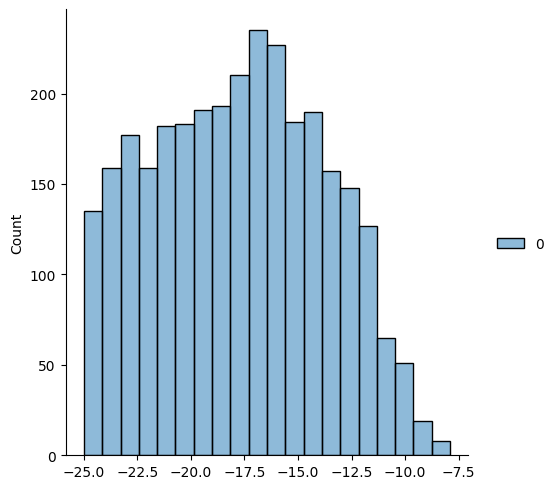

In [31]:
sns.displot(hmc_samples['linear.bias']);

In [32]:
np.median(hmc_samples['linear.weight'])

-34.716686

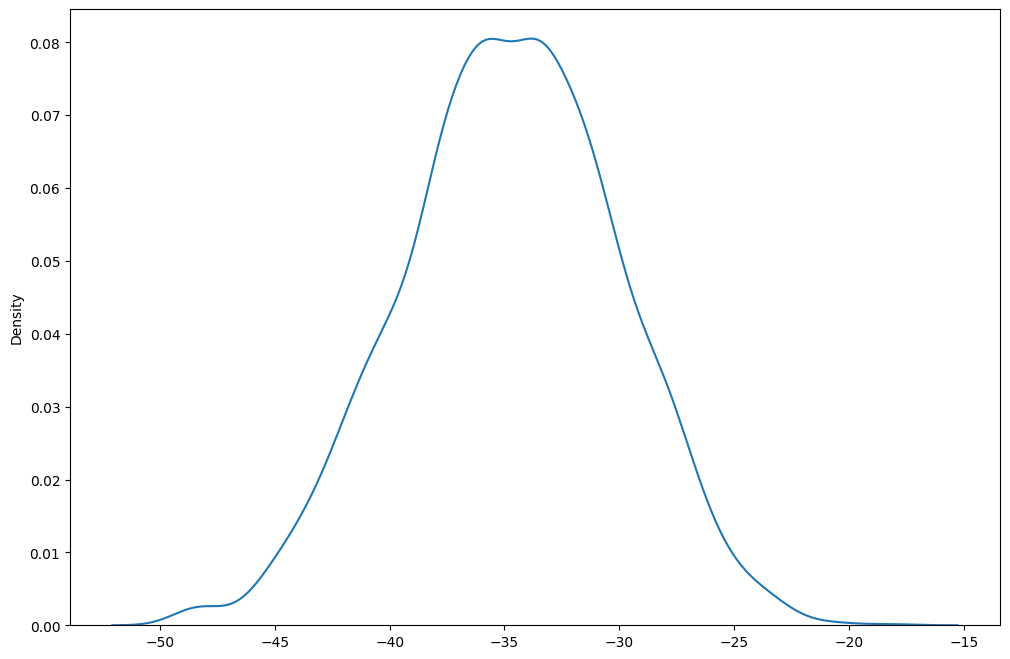

In [33]:
sns.kdeplot(hmc_samples['linear.weight'][:,0,0]);

In [34]:
print(clf.coef_)
print(clf.intercept_)

[[-38.69692782]]
[-21.54793048]


## So, this appears to work in 1D 
## Let's try predicting the multinomial logit

### note: due to perfect separation of setosa, this fails to converge for frequentist solution

In [35]:
import statsmodels.formula.api as smf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [36]:
mod = smf.mnlogit(formula='iris_type ~ sepal_length + sepal_width + petal_length + petal_width', data=X)

In [37]:
result = mod.fit()
print(result.summary())

         Current function value: 0.039662
         Iterations: 35
                          MNLogit Regression Results                          
Dep. Variable:              iris_type   No. Observations:                  150
Model:                        MNLogit   Df Residuals:                      140
Method:                           MLE   Df Model:                            8
Date:                Fri, 01 Apr 2022   Pseudo R-squ.:                  0.9639
Time:                        02:55:21   Log-Likelihood:                -5.9493
converged:                      False   LL-Null:                       -164.79
Covariance Type:            nonrobust   LLR p-value:                 7.055e-64
 iris_type=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       28.6122   4.64e+05   6.17e-05      1.000   -9.09e+05    9.09e+05
sepal_length    -6.5350   1.41e+06  -4.65e-06      1.000   

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [38]:
from torch import nn
from pyro.nn import PyroSample, PyroModule

class BayesianMultinomialLogisticRegression(PyroModule):
    def __init__(self, in_features, out_features = 1, bias = True):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(-10., 5.).expand([out_features, in_features]).to_event(2))
        if bias:
          self.linear.bias = PyroSample(dist.Normal(-1., 2.).expand([out_features]).to_event(1))
        
    def forward(self, x, y=None):
        logits = self.linear(x).squeeze(-1)

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Categorical(logits=logits), obs=y)
        return logits

In [39]:
model_2 = BayesianMultinomialLogisticRegression(4,1)

In [40]:
guide_2 = AutoMultivariateNormal(model_2, init_loc_fn=init_to_mean)

In [41]:
def train(model, guide, lr=0.1, n_steps=4000):
    pyro.set_rng_seed(1)
    pyro.clear_param_store()
    
    gamma = 0.01  # final learning rate will be gamma * initial_lr
    lrd = gamma ** (1 / n_steps)
    adam = pyro.optim.ClippedAdam({'lr': lr, 'lrd': lrd})

    svi = SVI(model, guide, adam, loss=Trace_ELBO())

    for i in range(n_steps):
        elbo = svi.step(data, target)
        if i % 500 == 0:
          print(f"Elbo loss: {elbo}")


In [42]:
data = tensor(X[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values, dtype=torch.float)
target = tensor(X['iris_type'].values, dtype=torch.float)

data.size(), target.size()

(torch.Size([150, 4]), torch.Size([150]))

In [43]:
%%time
train(model_2, guide_2)

Elbo loss: 3802.357560634613
Elbo loss: 550.3789377212524
Elbo loss: 550.4912233352661
Elbo loss: 550.727371096611
Elbo loss: 550.7081682682037
Elbo loss: 550.9701430797577
Elbo loss: 550.9141886234283
Elbo loss: 550.7344247102737
CPU times: user 16.2 s, sys: 55.6 ms, total: 16.3 s
Wall time: 17.9 s


In [44]:
from pyro.infer import MCMC, NUTS
nuts_kernel = NUTS(model_2)
mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=1500)
mcmc.run(data, target)

Sample: 100%|██████████| 3500/3500 [01:01, 57.18it/s, step size=5.27e-01, acc. prob=0.901]


In [45]:
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

In [46]:
hmc_samples.keys()

dict_keys(['linear.bias', 'linear.weight'])

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  "Could not get vectorized trace, log_likelihood group will be omitted. "


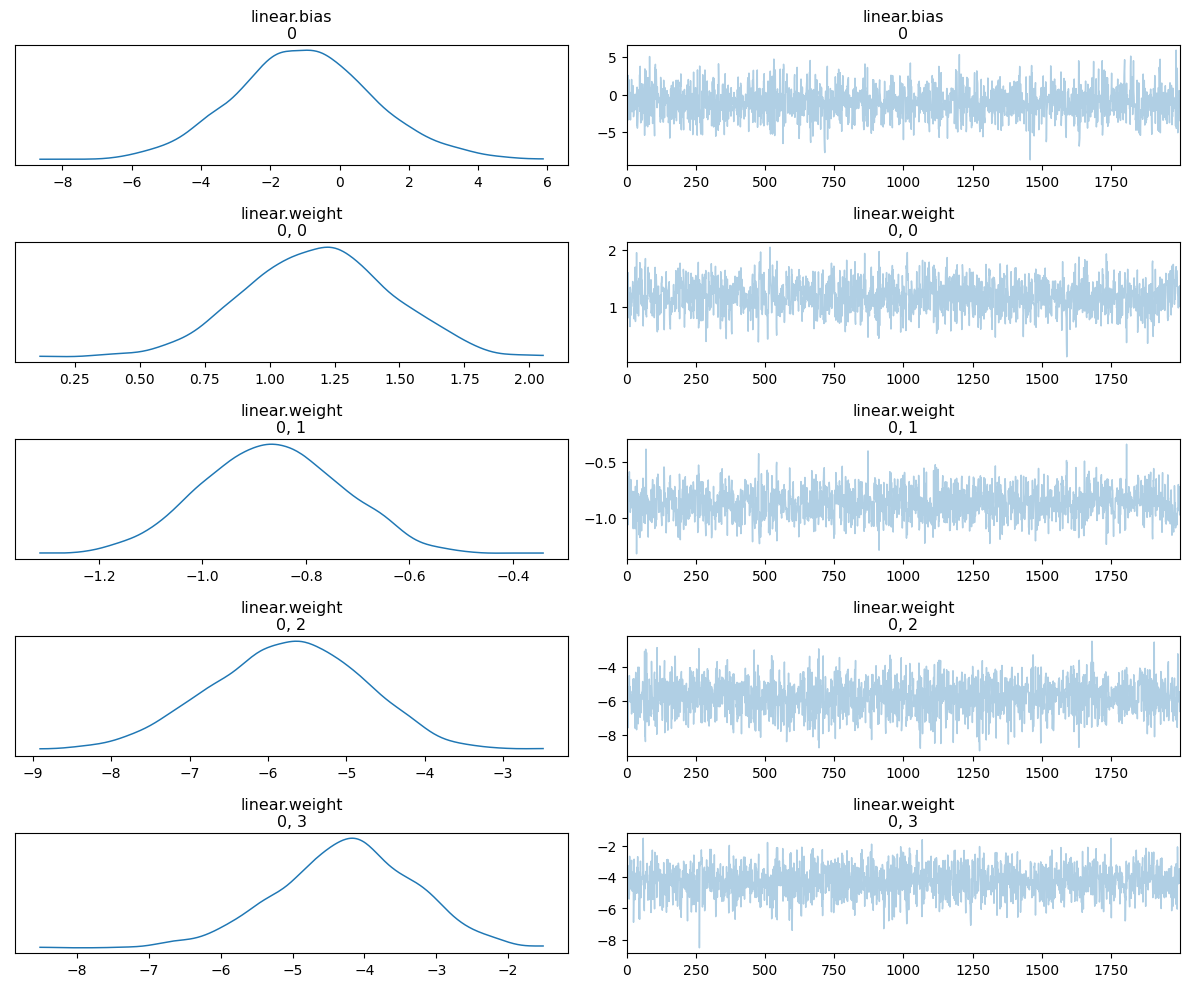

In [47]:
import arviz as az

az_data = az.from_pyro(mcmc)
az.plot_trace(az_data, compact=False);
plt.tight_layout()